# Sentiment analysis for tweets (1 Workshop AI)
#### Maicol Carvajal - Cristian Velasco - Bryan Bohorquez - Camilo Ocampo

### Using the next dataset we want to analyze sentiments: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset?resource=download

## Self made questions for the end:
#### Which feeling predominate in the whole dataset?
#### More than the 30% of the tweets contain negative sentiments?
#### Which model can get a higher accuracy / precission? (Between logistic regression and LSTM)
#### Which is the word most used and which are the least used?

## Importing pandas to get the dataset

In [32]:
import pandas as pd

## Uploading data and looking up the structure

In [33]:
df = pd.read_csv("Files/Tweets.csv")
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


#### We got a dataset that contains 4 columns: 
##### * An id
##### * The complete review
##### * Selected text (that show us the relation with the sentiment) 
##### * And finally the sentiment: the value that we are going to work on

## Cleaning data (preprocessing)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [35]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [36]:
nulls = df.loc[df.isnull().any(axis=1)] # Checking out if we have null data, axis = 1 checks column by column
nulls

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [37]:
# As we can see, the row 314 contains null content, we are going to delete it, (avoid data noise)
df.loc[314,:]

textID           fdb77c3752
text                    NaN
selected_text           NaN
sentiment           neutral
Name: 314, dtype: object

In [38]:
# Deleting the index 314 from df
df = df.drop(314)

In [39]:
# Checking again if we have null values
nulls = df.loc[df.isnull().any(axis=1)]
nulls # Empty: we got the dataset with values in every row

,textID,text,selected_text,sentiment


## Important Values

#### How many tweets are positive, negative and neutro?

In [40]:
negativeval = (df['sentiment'] == 'negative').sum()
print(f'# of negatives tweets: {negativeval}')

# of negatives tweets: 7781


In [41]:
positiveval = (df['sentiment'] == 'positive').sum()
print(f'# of positives tweets: {positiveval}')

# of positives tweets: 8582


In [42]:
neutralval = (df['sentiment'] == 'neutral' ).sum()
print(f'# of neutral tweets: {neutralval}')

# of neutral tweets: 11117


In [43]:
wholeval = len(df)
print(f'Total of tweets: {wholeval}')

positive_percent = (positiveval * 100) / wholeval
negative_percent = (negativeval * 100) / wholeval
neutral_percent = (neutralval * 100) / wholeval

print(f'''\nPERCENTS %:\n
Positive percent: {positive_percent}%
Negative percent: {negative_percent}%
Neutral percent: {neutral_percent}%''')

Total of tweets: 27480

PERCENTS %:

Positive percent: 31.229985443959244%
Negative percent: 28.315138282387192%
Neutral percent: 40.45487627365357%


## Wordcloud before cleaning data

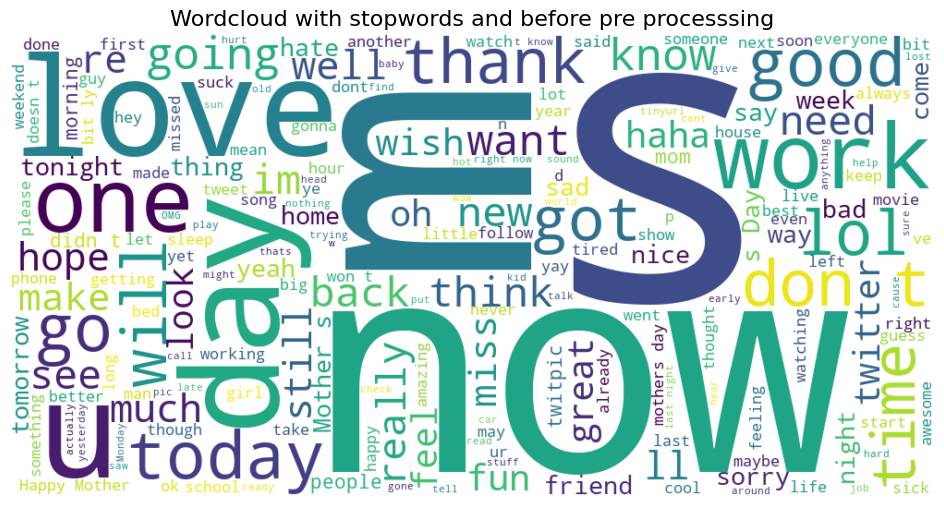

In [44]:
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud


whole_text = ''.join(df['text'].astype(str))

wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    width=1000,
    height=500
).generate(whole_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud with stopwords and before pre processsing', fontsize=16)
plt.show()

## Cleaning more data

### Here we define the stopwords

In [45]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

custom_words = {
    # Estados de EE.UU.
    'usa', 'america', 'minnesota', 'texas', 'florida', 'california', 'ohio', 'georgia', 'illinois', 'newyork',
    'washington', 'oregon', 'nevada', 'arizona', 'michigan', 'indiana', 'colorado', 'wisconsin', 'virginia',
    'maryland', 'pennsylvania', 'tennessee', 'kentucky', 'alabama', 'iowa', 'oklahoma', 'kansas', 'utah',
    'arkansas', 'mississippi', 'louisiana', 'northcarolina', 'southcarolina', 'northdakota', 'southdakota',
    'newmexico', 'newjersey', 'connecticut', 'massachusetts', 'vermont', 'maine', 'delaware', 'alaska', 'hawaii', 
    'san', 'diego',

    # Países y ciudades
    'colombia', 'mexico', 'canada', 'argentina', 'chile', 'peru', 'ecuador', 'venezuela', 'brazil', 'spain',
    'france', 'italy', 'germany', 'england', 'uk', 'japan', 'china', 'india', 'russia', 'turkey', 'australia',
    'bogota', 'medellin', 'miami', 'losangeles', 'chicago', 'london', 'paris', 'madrid', 'berlin', 'tokyo',
    'newdelhi', 'beijing', 'seoul', 'sydney', 'barcelona', 'rome', 'amsterdam', 'toronto', 'lisbon', 'dubai',

    # Fechas y días
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',

    # Palabras generales y sociales
    'people', 'thing', 'someone', 'everyone', 'today', 'tomorrow', 'yesterday',
    'video', 'photo', 'picture', 'account', 'follow', 'retweet', 'reply', 'tweet', 'thread',
    'please', 'thanks', 'thankyou', 'lol', 'omg', 'haha', 'wow', 'yeah', 'okay', 'ok', 'hey',
    'guys', 'girl', 'boy', 'man', 'woman', 'team', 'game', 'season', 'year', 'month', 'day', 'night',
    'news', 'update', 'breaking', 'post', 'share', 'check', 'link', 'page', 'website', 'online',
    'followme', 'followers', 'likes', 'comments', 'bio', 'profile', 'feed', 'story', 'stories',

    # Marcas y plataformas
    'apple', 'samsung', 'google', 'amazon', 'microsoft', 'netflix', 'spotify', 'tiktok', 'youtube', 'instagram',
    'facebook', 'twitter', 'x', 'snapchat', 'linkedin', 'whatsapp', 'telegram', 'discord', 'reddit', 'pinterest',
    'nasa', 'nike', 'adidas', 'coca', 'pepsi', 'tesla', 'uber', 'airbnb', 'zoom',

    # Conceptos neutros
    'stuff', 'something', 'anything', 'everything', 'somebody', 'anybody', 'nobody',
    'place', 'time', 'moment', 'situation', 'case', 'point', 'example', 'way', 'fact',
    'new', 'old', 'next', 'last', 'another', 'same', 'different', 'few', 'many', 'most', 'more', 'less',
    'every', 'each', 'whole', 'entire', 'lot', 'lots', 'kind', 'type', 'sort',
    'back', 'front', 'side', 'top', 'bottom', 'left', 'right', 'center', 'middle',
    'home', 'work', 'school', 'office', 'class', 'job', 'city', 'country', 'miss',

    # Roles laborales
    'developer', 'engineer', 'programmer', 'designer', 'architect', 'manager', 'director', 'coordinator', 'administrator',
    'supervisor', 'assistant', 'associate', 'consultant', 'intern', 'trainee', 'specialist', 'technician', 'analyst',
    'operator', 'executive', 'ceo', 'cto', 'cfo', 'founder', 'lead', 'senior', 'junior', 'employee', 'worker', 'staff',
    'teacher', 'professor', 'researcher', 'student', 'mentor', 'coach', 'trainer', 'salesperson', 'seller', 'buyer',
    'marketer', 'recruiter', 'hr', 'humanresources', 'accountant', 'lawyer', 'doctor', 'nurse', 'driver', 'chef', 'waiter',
    'bartender', 'cashier', 'security', 'cleaner', 'assistantmanager', 'teamlead', 'productmanager', 'projectmanager',
    'softwareengineer', 'frontenddeveloper', 'backenddeveloper', 'fullstackdeveloper', 'datascientist', 'machinelearning',
    'devops', 'sysadmin', 'qa', 'tester', 'support', 'customer', 'client', 'user', 'agent', 'consulting', 'freelancer', 'boss',

    # Roles familiares y sociales
    'wife', 'father', 'mother', 'daughter', 'daughters',
    'brother', 'brothers', 'sister', 'sisters', 'uncle', 'uncles', 'aunt', 'aunts',
    'cousin', 'cousins', 'grandfather', 'grandmother', 'grandparents', 'parents',
    'family', 'families', 'child', 'children', 'baby', 'babies',
    'citizen', 'citizens', 'neighbor', 'neighbors', 'friend', 'friends', 'enemy', 'enemies',
    'guest', 'guests', 'visitor', 'visitors', 'member', 'members', 'participant', 'participants',
    'leader', 'leaders', 'follower', 'followers', 'teammate', 'teammates', 'classmate', 'classmates',
    'worker', 'workers', 'volunteer', 'volunteers', 'student', 'students', 'teacher', 'teachers',
    'professor', 'professors', 'doctor', 'doctors', 'nurse', 'nurses', 'patient', 'patients',
    'officer', 'officers', 'soldier', 'soldiers', 'police', 'judge', 'lawyer', 'attorney', 'attorneys',
    'client', 'clients', 'customer', 'customers', 'user', 'users', 'owner', 'owners',
    'buyer', 'buyers', 'seller', 'sellers', 'artist', 'artists', 'writer', 'writers',
    'actor', 'actors', 'actress', 'actresses', 'singer', 'singers', 'musician', 'musicians',
    'player', 'players', 'coach', 'coaches', 'fan', 'fans', 'supporter', 'supporters',
    'voter', 'voters', 'resident', 'residents',

    # Verbos sin carga emocional
    'wonder', 'wondered', 'wondering',
    'manage', 'managed', 'managing',
    'handle', 'handled', 'handling',
    'mark', 'marked', 'marking',
    'count', 'counted', 'counting',
    'measure', 'measured', 'measuring',
    'record', 'recorded', 'recording',
    'report', 'reported', 'reporting',
    'notice', 'noticed', 'noticing',
    'reach', 'reached', 'reaching',
    'fit', 'fitted', 'fitting',
    'match', 'matched', 'matching',
    'fill', 'filled', 'filling',
    'pass', 'passed', 'passing',
    'fail', 'failed', 'failing',
    'deliver', 'delivered', 'delivering',
    'receive', 'received', 'receiving',
    'send', 'sent', 'sending',
    'copy', 'copied', 'copying',
    'paste', 'pasted', 'pasting',
    'apply', 'applied', 'applying',
    'compare', 'compared', 'comparing',
    'explain', 'explained', 'explaining',
    'describe', 'described', 'describing',
    'define', 'defined', 'defining',
    'list', 'listed', 'listing',
    'note', 'noted', 'noting',
    'refer', 'referred', 'referring',
    'depend', 'depended', 'depending',
    'relate', 'related', 'relating',
    'connect', 'connected', 'connecting',
    'attach', 'attached', 'attaching',
    'fix', 'fixed', 'fixing',
    'adjust', 'adjusted', 'adjusting',
    'set', 'setting',
    'arrange', 'arranged', 'arranging',
    'organize', 'organized', 'organizing',
    'prepare', 'prepared', 'preparing',
    'plan', 'planned', 'planning',
    'design', 'designed', 'designing',
    'complete', 'completed', 'completing',
    'finish', 'finished', 'finishing',
    'review', 'reviewed', 'reviewing',
    'update', 'updated', 'updating',
    'edit', 'edited', 'editing',
    'save', 'saved', 'saving',
    'load', 'loaded', 'loading',
    'install', 'installed', 'installing',
    'test', 'tested', 'testing',
    'verify', 'verified', 'verifying',
    'confirm', 'confirmed', 'confirming',
    'support', 'supported', 'supporting',
    'control', 'controlled', 'controlling',
    'operate', 'operated', 'operating',
    'perform', 'performed', 'performing',
    'calculate', 'calculated', 'calculating',
    'estimate', 'estimated', 'estimating',
    'analyze', 'analyzed', 'analyzing',
    'evaluate', 'evaluated', 'evaluating',
    'measure', 'measured', 'measuring',
    'assess', 'assessed', 'assessing',
    'improve', 'improved', 'improving',
    'increase', 'increased', 'increasing',
    'decrease', 'decreased', 'decreasing',
    'reduce', 'reduced', 'reducing',
    'maintain', 'maintained', 'maintaining',
    'store', 'stored', 'storing',
    'contain', 'contained', 'containing',
    'include', 'included', 'including',
    'require', 'required', 'requiring',
    'provide', 'provided', 'providing',
    'supply', 'supplied', 'supplying',
    'replace', 'replaced', 'replacing',
    'remove', 'removed', 'removing',
    'clean', 'cleaned', 'cleaning',
    'wash', 'washed', 'washing',
    'dry', 'dried', 'drying',
    'cook', 'cooked', 'cooking',
    'feed', 'fed', 'feeding',
    'wear', 'wore', 'worn', 'wearing',
    'sit', 'sat', 'sitting',
    'stand', 'stood', 'standing',
    'lie', 'lay', 'lain', 'lying',
    'rest', 'rested', 'resting',
    'sleep', 'slept', 'sleeping',
    'wake', 'woke', 'woken', 'waking',
    'watch', 'watched', 'watching',
    'listen', 'listened', 'listening',
    'speak', 'spoke', 'spoken', 'speaking',
    'talk', 'talked', 'talking',
    'read', 'reading',
    'write', 'wrote', 'written', 'writing',
    'print', 'printed', 'printing',
    'draw', 'drew', 'drawn', 'drawing',
    'release', 'releases', 'released',
    'build', 'built', 'building',
    'cut', 'cutting',
    'join', 'joined', 'joining',
    'cover', 'covered', 'covering',
    'drop', 'dropped', 'dropping',
    'learn', 'learnt', 'learned',
    'throw', 'threw', 'thrown', 'throwing',
    'push', 'pushed', 'pushing',
    'pull', 'pulled', 'pulling',

    # Misc
    'wish', 'ive', 'rake', 'make', 'made', 'clear', 'net', 'dont', 'force', 
    'break', 'probably', 'proly', 'already', 'right', 'now', 'https',
    'u', 'd', 'could', 'couldnt', 'would', 'wouldnt', 'come', 'see', 'afford', 'denver',
    'cant', 'buy', 'bought', 'hun', 'care', 'put', 'putted', 'im', 'weekend', 'plugging', 'pluggings'
}


stop_words.update(custom_words)

### Without more spaces / stopwords / mayus / special characters

In [46]:
import unicodedata
import re

def minusAndSpecialCharacteres(df):

    def clean_text(text):
        if isinstance(text, str):
            text = unicodedata.normalize("NFKD", text)
            text = ''.join(ch for ch in text if not unicodedata.combining(ch)) 
            text = ''.join(ch for ch in text if unicodedata.category(ch)[0] != 'C')           
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'www\S+', '', text)
            text = text.lower()
            text = re.sub(r'[^a-z\s]', '', text)  # special characters and numbers
            text = re.sub(r'\s+', ' ', text)  # if there are more spaces than one, it clears it
            text = text.strip()  # no spaces at the beggining or the end
            text = ' '.join([word for word in text.split() if word not in stop_words]) # Replace stopwords for ' '
        return text

    # Here we ask to the functions that's is inside to change the values in the text column for them that it is supposed to give
    df['text'] = df['text'].apply(clean_text)
    return df

# Use the function that by its self calls the other one to make the changes that we wanna
df = minusAndSpecialCharacteres(df)
df # Actually works as we wait :D

,textID,text,selected_text,sentiment
0,cb774db0d1,id responded going,"I`d have responded, if I were going",neutral
1,549e992a42,sooo sad,Sooo SAD,negative
2,088c60f138,bullying,bullying me,negative
3,9642c003ef,interview leave alone,leave me alone,negative
4,358bd9e861,sons,"Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,husband lost,d lost,negative
27477,4f4c4fc327,devs lang agile ccnet,", don`t force",negative
27478,f67aae2310,yay good enjoy need hectic take xxxx,Yay good for both of you.,positive
27479,ed167662a5,worth,But it was worth it ****.,positive


## Wordcloud after cleaning data

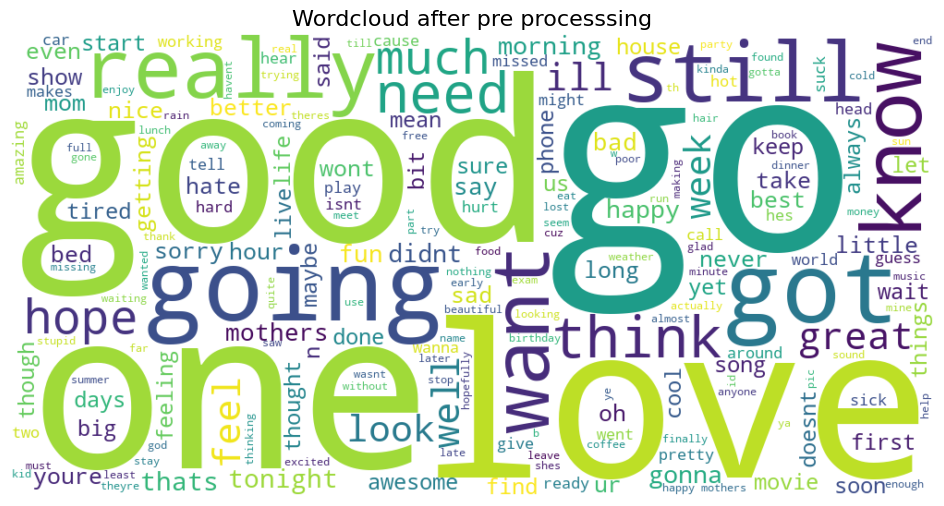

In [47]:
whole_text = ''.join(df['text'].astype(str))

wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    width=1000,
    height=500
).generate(whole_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud after pre processsing', fontsize=16)
plt.show()

## Vectorizer process

### Check if we have df['text'] with 0 characters

In [48]:
# Null values in the text column
null_texts = df['text'].isnull()
print(f"{null_texts.sum()}") # We can continue working with the df, we don't have any text without value

0


### Lenght of strings in our dataset

In [49]:
df['text_length_chars'] = df['text'].str.len() # Lenght of strings for every document

print("Lenght of strings:")
print(f"Min: {df['text_length_chars'].min()}")
print(f"Max: {df['text_length_chars'].max()}")
print(f"Average: {df['text_length_chars'].mean():.2f}")

Lenght of strings:
Min: 0
Max: 123
Average: 33.98


In [50]:
df

,textID,text,selected_text,sentiment,text_length_chars
0,cb774db0d1,id responded going,"I`d have responded, if I were going",neutral,18
1,549e992a42,sooo sad,Sooo SAD,negative,8
2,088c60f138,bullying,bullying me,negative,8
3,9642c003ef,interview leave alone,leave me alone,negative,21
4,358bd9e861,sons,"Sons of ****,",negative,4
...,...,...,...,...,...
27476,4eac33d1c0,husband lost,d lost,negative,12
27477,4f4c4fc327,devs lang agile ccnet,", don`t force",negative,21
27478,f67aae2310,yay good enjoy need hectic take xxxx,Yay good for both of you.,positive,36
27479,ed167662a5,worth,But it was worth it ****.,positive,5


### Total words and unique words

In [51]:
# Lenght of word for every document
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print("\nStats word count:")
print(df['word_count'].describe())

# Quantile/"Percentil" for maxlen
percentiles = [1, 25, 50, 75, 80, 90, 95, 99, 100]
for p in percentiles:
    value = df['word_count'].quantile(p/100)
    print(f"Quantile {p}%: {value} words") # The x% of tweets has #x of words



Stats word count:
count    27480.000000
mean         5.554330
std          3.239378
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         21.000000
Name: word_count, dtype: float64
Quantile 1%: 0.0 words
Quantile 25%: 3.0 words
Quantile 50%: 5.0 words
Quantile 75%: 8.0 words
Quantile 80%: 8.0 words
Quantile 90%: 10.0 words
Quantile 95%: 11.049999999999272 words
Quantile 99%: 14.0 words
Quantile 100%: 21.0 words


In [52]:
df

,textID,text,selected_text,sentiment,text_length_chars,word_count
0,cb774db0d1,id responded going,"I`d have responded, if I were going",neutral,18,3
1,549e992a42,sooo sad,Sooo SAD,negative,8,2
2,088c60f138,bullying,bullying me,negative,8,1
3,9642c003ef,interview leave alone,leave me alone,negative,21,3
4,358bd9e861,sons,"Sons of ****,",negative,4,1
...,...,...,...,...,...,...
27476,4eac33d1c0,husband lost,d lost,negative,12,2
27477,4f4c4fc327,devs lang agile ccnet,", don`t force",negative,21,4
27478,f67aae2310,yay good enjoy need hectic take xxxx,Yay good for both of you.,positive,36,7
27479,ed167662a5,worth,But it was worth it ****.,positive,5,1


In [53]:
# We take all the words and see those unique ones
all_words = []
for text in df['text']:
    words = str(text).split()  # Split for add any word into the list of all_words
    all_words.extend(words)

# Unique words calc
unique_words = set(all_words) # set just put those unique words
total_unique_words = len(unique_words) # Give us our number of unique words

print(f"Unique words: {total_unique_words}")
print(f"Total words: {len(all_words)}")

Unique words: 25956
Total words: 152633


In [54]:
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(f"Initial texts: {len(df)}")

# Count word frequency in entire corpus
word_counts = Counter()
for text in df['text']:
    if isinstance(text, str):
        word_counts.update(text.split())

# Keep only words that appear 2+ times
valid_words = {word for word, count in word_counts.items() if count > 1}

print(f"Unique words removed: {len(word_counts) - len(valid_words)}")
print(f"Valid words (2+ occurrences): {len(valid_words)}")

# Filter texts keeping only valid words
def filter_unique_words(text):
    if not isinstance(text, str):
        return ""
    return ' '.join([w for w in text.split() if w in valid_words])

df['text'] = df['text'].apply(filter_unique_words)

# Remove rows with empty text
initial_rows = len(df)
df = df[df['text'].str.strip() != ""].reset_index(drop=True)
removed_rows = initial_rows - len(df)

print(f"Rows removed (empty text): {removed_rows}")
print(f"Final documents: {len(df)}")

# Create tokenizer and generate sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# Calculate max length (95th percentile)
sequence_lengths = [len(seq) for seq in sequences]

maxlen = int(pd.Series(sequence_lengths).quantile(0.95))
maxlen

print(f"\nMax length (95th percentile): {maxlen}")
print(f"Average length: {sum(sequence_lengths) / len(sequence_lengths):.1f}")
print(f"Min length: {min(sequence_lengths)}")
print(f"Max length: {max(sequence_lengths)}")

# Apply padding
padded_sequences = pad_sequences(
    sequences,
    maxlen=maxlen,
    padding='post',
    truncating='post'
)

Initial texts: 27480
Unique words removed: 16604
Valid words (2+ occurrences): 9352
Rows removed (empty text): 678
Final documents: 26802

Max length (95th percentile): 10
Average length: 5.1
Min length: 1
Max length: 18


In [55]:
df

,textID,text,selected_text,sentiment,text_length_chars,word_count
0,cb774db0d1,id going,"I`d have responded, if I were going",neutral,18,3
1,549e992a42,sooo sad,Sooo SAD,negative,8,2
2,9642c003ef,interview leave alone,leave me alone,negative,21,3
3,358bd9e861,sons,"Sons of ****,",negative,4,1
4,28b57f3990,best rangers forum earth,http://www.dothebouncy.com/smf - some shameles...,neutral,34,5
...,...,...,...,...,...,...
26797,4eac33d1c0,husband lost,d lost,negative,12,2
26798,4f4c4fc327,devs lang agile,", don`t force",negative,21,4
26799,f67aae2310,yay good enjoy need hectic take xxxx,Yay good for both of you.,positive,36,7
26800,ed167662a5,worth,But it was worth it ****.,positive,5,1


#### Verification of the functionality of sequences

In [56]:
sequences

[[130, 7],
 [221, 29],
 [801, 167, 284],
 [2248],
 [46, 4687, 2506, 958],
 [26, 1769],
 [349, 334],
 [1770, 1907, 2826, 323, 959],
 [19, 6, 2507, 2827, 3254, 6211, 316, 51, 33, 3, 452],
 [12, 12, 4, 128, 6, 775, 1908],
 [299, 652, 4688],
 [15, 5, 155, 32, 140, 776],
 [3829],
 [1294, 18, 2249],
 [79, 3830, 6212, 380],
 [68, 398, 41, 2828, 156, 90, 6213, 31, 1216, 63],
 [33, 10],
 [121],
 [18, 28, 21, 78, 50],
 [199, 2075, 12, 406, 558, 1636, 960, 42, 2829, 1636],
 [77, 6214, 117],
 [146, 6215, 306, 86, 271, 362, 183, 1909],
 [961, 164, 394, 285, 865, 996],
 [208, 634, 436, 26, 1295],
 [28],
 [263, 923, 1158],
 [2250, 236, 6216, 4689, 26, 122, 777],
 [83, 735, 6217, 735, 55],
 [7, 212],
 [21, 6218, 2508, 1039, 6218],
 [4690, 8, 223, 219, 13, 19, 2251, 266],
 [24, 182, 195, 207],
 [548, 33, 108, 46, 37, 21, 123, 2252],
 [24, 183, 1518, 4691, 1362, 1771, 1363, 1089],
 [1217, 3831, 736, 507, 398, 224, 17, 831],
 [12, 248, 141, 1519, 1439, 3255, 558, 241, 3832],
 [1440],
 [49, 9, 572, 6219, 

#### Verification of the functionality of padded_sequences

In [57]:
padded_sequences

array([[ 130,    7,    0, ...,    0,    0,    0],
       [ 221,   29,    0, ...,    0,    0,    0],
       [ 801,  167,  284, ...,    0,    0,    0],
       ...,
       [  84,    2,  165, ...,    0,    0,    0],
       [ 439,    0,    0, ...,    0,    0,    0],
       [5475,    7, 1769, ...,    0,    0,    0]],
      shape=(26802, 10), dtype=int32)

In [58]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])
class_names = label_encoder.classes_

## Model and training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("Preparing data...")

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])
class_names = label_encoder.classes_

print("Class distribution:")
for i, class_name in enumerate(class_names):
    count = np.sum(y == i)
    print(f"  {class_name}: {count} tweets ({count/len(y)*100:.1f}%)")

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nData split:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

print("\nBuilding ultra-simple model to avoid overfitting...")

vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel summary:")
model.summary()

print("\nTraining simple model...")

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

print("Training completed")

print("\nEvaluating model...")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nClassification report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

print("\nConfusion matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print(conf_matrix)

print("\nAccuracy per class:")
for i, class_name in enumerate(class_names):
    mask = y_test == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_test[mask], y_pred_classes[mask])
        print(f"  {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

if accuracy >= 0.80:
    print(f"\nObjective achieved! Accuracy >= 80%")
else:
    print(f"\nObjective not reached. Accuracy < 80%")
    print(f"\nNote: Maximum achievable with this data may be around {accuracy*100:.1f}%")
    print("Consider improving data cleaning or getting more/better quality data")

print("\nProcess completed!")

Preparing data...
Class distribution:
  negative: 7689 tweets (28.7%)
  neutral: 10638 tweets (39.7%)
  positive: 8475 tweets (31.6%)

Data split:
  X_train: (21441, 10)
  X_test: (5361, 10)

Building ultra-simple model to avoid overfitting...

Model summary:


c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training simple model...
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4665 - loss: 1.0607 - val_accuracy: 0.6021 - val_loss: 0.9723
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6040 - loss: 0.8642 - val_accuracy: 0.6553 - val_loss: 0.8146
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6907 - loss: 0.7320 - val_accuracy: 0.6495 - val_loss: 0.7979
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7393 - loss: 0.6535 - val_accuracy: 0.6728 - val_loss: 0.7739
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7741 - loss: 0.5942 - val_accuracy: 0.6590 - val_loss: 0.7988
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7960 - loss: 0.5509 - val_accuracy: 0.6461 - val_loss: 0.8355
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8141 - loss: 0.5064 - val_accuracy: 0.6484 - val_loss: 0.8665
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8292 - loss: 0.4789 - val_ac

## Accuracy


3. Confusion Matrix (Combined):


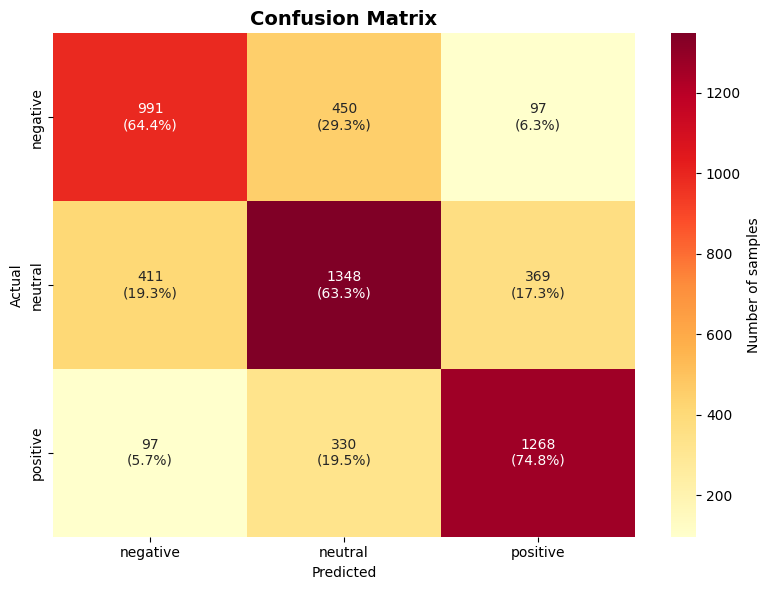

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix with both counts and percentages
def plot_confusion_matrix_combined(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Creates a confusion matrix showing both counts and percentages
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    annotations = []
    for i in range(len(cm)):
        row = []
        for j in range(len(cm)):
            row.append(f"{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)")
        annotations.append(row)
    
    sns.heatmap(cm, 
                annot=annotations, 
                fmt='', 
                cmap='YlOrRd', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Number of samples'})
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Combined confusion matrix
print("\nConfusion Matrix (Combined):")
plot_confusion_matrix_combined(y_test, y_pred_classes, class_names)
